In [1]:
import torch
import os
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper).

In [2]:
vgg = models.vgg19(pretrained=True)

Load the model onto your GPU (if you have one) and "freeze" it, preventing any additional gradient updates from occurring to the already trained model. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old parameter tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg = vgg.to(device)
for param in vgg.features.parameters(): # stop training the net
    param.requires_grad = False

Confirm that the network really is loaded onto the GPU.

In [4]:
next(vgg.parameters()).is_cuda # Should be `True` if you have a GPU

True

Optionally, we can also replace all the max pool layers in our vgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [5]:
vgg_layers = list(vgg.children())[0]

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

Lastly, we'll remove the fully connected layers from our pretained vgg network. We don't need these for texture synthesis, and leaving them in limits us to input images of size 224x224 only.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [6]:
useful_layers = list(vgg.children())[0]
vgg = nn.Sequential(useful_layers)
len(list(vgg.children())[0]) # should be 37

37

## Perpairing the example texture

The pre-trained networks from torchvision.models need to be passed inputs in a certain format, so we're going to add a transform to apply those transformations to all the image's we're dealing with. We also define a helper function `image_loader` which takes a relative image path, loads the image into a tensor, applies the relevant transformations and returns it.

`show_image` makes it easier to view images we load using `image_loader`. Pytorch doesn't seem to have any good method for visualizing tensors, so we convert the tensor to a numpy array, transpose it and then plot that using matplotlib.

**Note:** `unsqueeze()` is a pytorch function that adds extra dimensions to tensors. We're using it here because vgg19 only takes mini-batches of images, and we're working with a single image. We use `.unsqueeze()` to add the extra dimension to our image tensor and trick vgg into thinking it's dealing with a small minibatch of images. 

**Note 2:** For classification vgg19 expects input images to be normalized according to imagenet mean values. The commented out line below applies this transform. We're not doing classification though and *should not* add it here. It would cause our sample textures to be optimized to look like the *normalized* version of the example texture (i.e. off color and weird). See `data/samples/stones-normalized` for what happened to me. We can also ignore the usual size constraint of 224x224 since convolutional layers are size-agonstic and we already removed all the fully connected layers.

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(320),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img_path = "data/examples/"
img_name = "beksinski.jpg" # we use this variable later
full_path = img_path + img_name

example_texture = img.image_loader(full_path, transform)
img.show_image(example_texture)

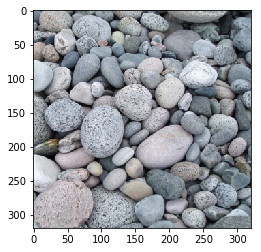

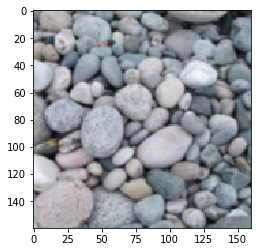

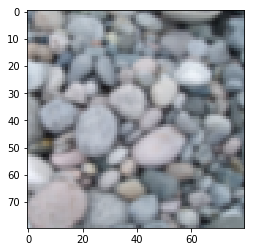

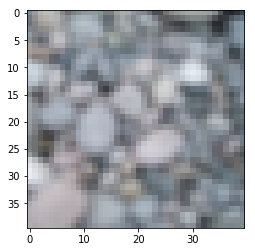

In [69]:
gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)

example_pyr = pyramid.gaussian_pyramid(example_texture, gaussian_kernel, max_levels=3)
for pyr_slice in example_pyr:
    img.show_image(pyr_slice)

## Extracting Layer activations

The guys in the paper defined the texture profile of the example texture as the **gram matrices** of the feature maps of some of the convolutional or pooling layers in vgg19 after feeding in that example texture. In order to get at these feature maps we're going to use pytorch's hook feature. 

### Hooks

Basically hooks are classes with `.hook_fn`, `.__init__` and `close` methods. `__init__` should take a layer from a module and register the hook's `hook_fn` method on that layer. Whenever the layer is run from then on, `hook_fn` for that hook instance will be called, being passed in the model holding the layer, the layer's input and the layer's output in that order. Let's ignore `close()` for now.

In this case all we want to do is save the output of each layer, so we create a simple `hook_fn` that just saves the layer's output tensor on the hook instance for later use when called.

In [70]:
class Hook():
    features=None
    def __init__(self, layer): 
        self.hook = layer.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
    def close(self): 
        self.hook.remove()

The paper reccomends using the 3rd and 8th layers (only counting conv and pooling layers)

In [71]:
layer_feature_maps = []

all_layers = list(vgg.children())[0]

for index in [4, 12]:
    layer = all_layers[index]
    layer_name = layer.__class__.__name__
    if layer_name == "Conv2d"  or layer_name == 'MaxPool2d' or layer_name == 'AvgPool2d':
        layer_feature_maps.append(Hook(layer))

print(len(layer_feature_maps)) # should be 2

2


Now we have this function, let's use it to create a list of gram matrices, one for each layer we're interested in. This list represents all the summary statistics we will need from the example input. The values in this tensor will probably be tiny, or actually 0.

In [72]:
example_feature_pyr = []

for pyr_slice in example_pyr:
    vgg(pyr_slice)
    slice_stats = [stats.gram_matrix(layer.features) for layer in layer_feature_maps]
    print(len(slice_stats)) # should be 5
    print(slice_stats[0]) # should be a tensor. It will probably have very small values.
    example_feature_pyr.append(slice_stats)

2
tensor([[0.0011, 0.0000, 0.0021,  ..., 0.0010, 0.0005, 0.0005],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0021, 0.0000, 0.0106,  ..., 0.0047, 0.0010, 0.0025],
        ...,
        [0.0010, 0.0000, 0.0047,  ..., 0.0026, 0.0005, 0.0012],
        [0.0005, 0.0000, 0.0010,  ..., 0.0005, 0.0006, 0.0004],
        [0.0005, 0.0000, 0.0025,  ..., 0.0012, 0.0004, 0.0019]],
       device='cuda:0')
2
tensor([[0.0014, 0.0000, 0.0023,  ..., 0.0011, 0.0007, 0.0004],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0023, 0.0000, 0.0104,  ..., 0.0047, 0.0013, 0.0018],
        ...,
        [0.0011, 0.0000, 0.0047,  ..., 0.0026, 0.0007, 0.0009],
        [0.0007, 0.0000, 0.0013,  ..., 0.0007, 0.0008, 0.0004],
        [0.0004, 0.0000, 0.0018,  ..., 0.0009, 0.0004, 0.0014]],
       device='cuda:0')
2
tensor([[0.0021, 0.0000, 0.0029,  ..., 0.0014, 0.0009, 0.0006],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0029, 0.000

## Computing Loss

Next we need a way of generating a loss from the example summary statistics (above), and some sample summary statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). The paper recommends calculating the **mean squared error** loss between the two sets of gram matrices.

I had a lot of trouble with this. The losses were always tiny (probably because, as above, the gram matrices I calculated from the feature maps tended to hold super small values), and often resulted in outright 0 gradients. The hacky-as-balls solution I came up with was to literally just scale the loss by some factor before returning. Gross I know.

The paper also recommends using LBFGS to perform gradient updates. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html) for this which you should probably look up. The main takeaway is: if you're using `torch.optim.LBFGS()` as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. Because we can't pass any arguments to the `closure()` function directly, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

We'll also add our loss function to this class for conveniance.

In [76]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, example_feature_pyr, layer_feature_maps, scale):
        self.optimizer = optimizer
        self.sample = sample
        self.example_feature_pyr = example_feature_pyr
        self.model = model
        self.layer_feature_maps = layer_feature_maps
        self.scale = scale

    def loss_fn(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.example_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += torch.mean((sample_stats[j] - target_stats[j]).pow(2)) # mean squared error

        print("scale: {}".format(self.scale))
        return loss * self.scale
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=3)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            self.model(sample)
            sample_feature_pyr.append([stats.gram_matrix(layer.features) for layer in self.layer_feature_maps])

        loss = self.loss_fn(sample_feature_pyr)
        loss.backward()

        print("loss: {}".format(loss))

        return loss


## Create the Sample Texture

Nearly there. Now we need to create a random image that will eventually become out sample texture. We're going to pass this texture through our vgg network and keep performing gradient descent on it against the above loss function until its summary statistics more or less match the example texture.

We use numpy to create the random image here because numpy is generally better at operating on matrices. In particular we want to smoothen the image because real life images have a natural smoothness to them.


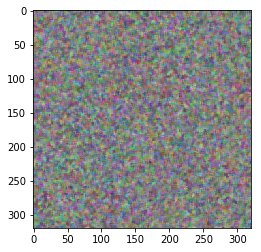

In [74]:
def random_image(blur=6):
    # create random noise numpy array
    np_sample = np.random.rand(320, 320, 3)

    # smooth it out (try commenting out this line and see the difference)
    np_sample = scipy.ndimage.filters.median_filter(np_sample, [blur, blur,1]) 

    # finally convert to a tensor with autograd enabled (since we're 
    # going to be performing gradient updates on this image)
    sample = torch.from_numpy(np_sample).float().permute(2, 0, 1).unsqueeze(0).to(device) 
    sample.requires_grad = True
    
    return sample

img.show_image(random_image(5))

## Generate the Sample Texture

And here we are. Basically all we do now is perform an arbitrary number of gradient updates on the random sample texture. Once that's done it should look a bit like the example texture (hopefully). To make this clean and reusable, we're going to pack this process into a class called `Synthesizer`, which will take in a bunch of hyperparameters and also save the generated textures as `.jpg`'s for viewing later.

First though, we're going to define some conveniance functions.

In [59]:
def make_optimizer(name, sample_texture, lr):
    if name == "LBFGS":
        return optim.LBFGS([sample_texture], lr=0.1)
    if name == "Adam":
        return optim.Adam([sample_texture], lr=0.1) 
    
    raise ValueError('Name was not a valid optimizer identifier')

### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. This way we can examine them at them at our leisure later. In particular I want to save a bunch of images throughout the generation process so I can observe how it's going. I'm going to give each image an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [60]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["layer_feature_maps", "model", "iterations", "id"]:
            if key == "name":
                id += params[key].replace(".jpg", "") + "-"
            else:
                id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Synthesizer

The only important method is `synthesize`, the rest of it is just there to save the sample textures to the right directories. Basically this method takes a bunch of hyperparameters, generates a (quasi) random image, and performs gradient updates on it for a given number of iterations using the `GradientStepper` class we defined earlier.

In [61]:
class Synthesizer():
    
    sample_directory = "data/samples"
    
    def __init__(self, params):
        self.save_mode = params["save_mode"]
        self.example_feature_pyr = params["example_feature_pyr"]
               
    def prepair_save_directory(self, params):
        self.identifier = params["id"]
        
        if self.save_mode == "final":
            self.dir_path = Synthesizer.sample_directory + "/lol"
            self.save_at = params["iterations"]
            
        elif self.save_mode == "throughout":
            self.dir_path = Synthesizer.sample_directory + "/" + self.identifier
            self.save_at = 1
        
        if not os.path.exists(self.dir_path):
            os.makedirs(self.dir_path)
    
    def save_path(self):
        if self.save_mode == "final":
            file_name = self.identifier
        elif self.save_mode == "throughout":
            file_name = self.save_at
        
        return "{}/{}.jpg".format(self.dir_path , file_name)
    
    def synthesize(self, params):
        sample_texture = random_image(params["blur"])
        optimizer = make_optimizer(params["optimizer"], sample_texture, params["lr"]) 
        stepper = GradientStepper(optimizer, params["model"], sample_texture, self.example_feature_pyr, params["layer_feature_maps"], params["scale"])
        
        self.prepair_save_directory(params)

        for i in range (params["iterations"]):
            if sample_texture.grad is not None:
                print(sample_texture.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                save_image(sample_texture, self.save_path())
                self.save_at *= 2

                if params["scale_decay"] > 0:
                    stepper.scale -= (stepper.scale / params["scale_decay"])
        
        return sample_texture

### Execution

Feel free to fiddle around with hyperparameters here, but I did a fair bit of fiddling myself, and to be honest  the only thing that seemed to make any real difference was the scale, which just needed to remain > 10,000.

In [ ]:
params = {
    "name": img_name,
    "layers": 5,
    "iterations": 128,
    "blur": 5,
    "scale_decay": 0, # 0 means no scale decay
    "scale": 100000,
    "model": vgg,
    "layer_feature_maps": layer_feature_maps,
    "optimizer": "LBFGS",
    "lr": 0.1,
}

meta_params = {
    "save_mode": "throughout" ,
    "example_feature_pyr": example_feature_pyr,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Synthesizer(meta_params)

for s in [100000]:
    for sd in [0]:
        for blur in [5]:
            params["scale_decay"] = sd
            params["scale"] = s
            params["blur"] = blur
            params["id"] = identifier(params) 

            print(params["id"])

            syn.synthesize(params)

stones-layers5-blur5-scale_decay0-scale100000-optimizerLBFGS-lr0.1
scale: 100000
loss: 1.0376251935958862
scale: 100000
loss: 1.0376088619232178
scale: 100000
loss: 0.957614541053772
scale: 100000
loss: 0.8979227542877197
scale: 100000
loss: 0.8514871001243591
scale: 100000
loss: 0.8073607087135315
scale: 100000
loss: 0.761309027671814
scale: 100000
loss: 0.723532497882843
scale: 100000
loss: 0.6844412088394165
scale: 100000
loss: 0.6398395895957947
scale: 100000
loss: 0.5986505150794983
scale: 100000
loss: 0.5473900437355042
scale: 100000
loss: 0.48634210228919983
scale: 100000
loss: 0.4061807096004486
scale: 100000
loss: 0.3273891508579254
scale: 100000
loss: 0.2553463876247406
scale: 100000
loss: 0.20287029445171356
scale: 100000
loss: 0.16255709528923035
scale: 100000
loss: 0.1327372044324875
scale: 100000
loss: 0.10907220840454102
tensor([6.9416e-06, 7.4040e-06, 9.1164e-06, 7.7659e-06], device='cuda:0')
scale: 100000
loss: 0.08995945751667023
scale: 100000
loss: 0.0748580545186996

scale: 100000
loss: 0.001677295076660812
scale: 100000
loss: 0.0016691377386450768
scale: 100000
loss: 0.0016620287206023932
scale: 100000
loss: 0.0016556472983211279
scale: 100000
loss: 0.001649392070248723
scale: 100000
loss: 0.0016430419636890292
scale: 100000
loss: 0.0016352644888684154
scale: 100000
loss: 0.0016283596633002162
scale: 100000
loss: 0.001621933188289404
scale: 100000
loss: 0.0016147424466907978
scale: 100000
loss: 0.0016095972387120128
scale: 100000
loss: 0.0016026441007852554
scale: 100000
loss: 0.001597090158611536
scale: 100000
loss: 0.0015913484385237098
scale: 100000
loss: 0.0015855665551498532
scale: 100000
loss: 0.0015796246007084846
scale: 100000
loss: 0.0015726492274552584
tensor([9.5192e-09, 5.9508e-09, 1.7436e-08, 1.6155e-08], device='cuda:0')
scale: 100000
loss: 0.0015672437148168683
scale: 100000
loss: 0.0015618674224242568
scale: 100000
loss: 0.0015559378080070019
scale: 100000
loss: 0.0015500739682465792
scale: 100000
loss: 0.0015452002407982945
scale:

scale: 100000
loss: 0.0011589507339522243
scale: 100000
loss: 0.0011576333781704307
scale: 100000
loss: 0.00115637865383178
scale: 100000
loss: 0.0011554536176845431
scale: 100000
loss: 0.001154181663878262
scale: 100000
loss: 0.0011531258933246136
scale: 100000
loss: 0.0011519043473526835
scale: 100000
loss: 0.001150814350694418
scale: 100000
loss: 0.0011494685895740986
scale: 100000
loss: 0.0011480929097160697
scale: 100000
loss: 0.0011469956953078508
scale: 100000
loss: 0.0011457034852355719
scale: 100000
loss: 0.0011446147691458464
scale: 100000
loss: 0.0011433020699769258
scale: 100000
loss: 0.0011420808732509613
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.0011409968137741089
scale: 100000
loss: 0.0011401341762393713
scale: 100000
loss: 0.0011389468563720584
scale: 100000
loss: 0.0011378409108147025
scale: 100000
loss: 0.0011368091218173504
scale: 100000
loss: 0.0011356446193531156
scale: 100000
loss: 0.0011345497332513332
scale: 100000
loss

scale: 100000
loss: 0.001017745933495462
scale: 100000
loss: 0.0010172174079343677
scale: 100000
loss: 0.0010167231084778905
scale: 100000
loss: 0.0010162191465497017
scale: 100000
loss: 0.0010158036602661014
scale: 100000
loss: 0.0010153111070394516
scale: 100000
loss: 0.0010148565052077174
scale: 100000
loss: 0.001014235313050449
scale: 100000
loss: 0.0010137467179447412
scale: 100000
loss: 0.00101336813531816
scale: 100000
loss: 0.001012853579595685
scale: 100000
loss: 0.0010123916435986757
scale: 100000
loss: 0.0010119759244844317
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.0010115192271769047
scale: 100000
loss: 0.0010109581053256989
scale: 100000
loss: 0.0010105441324412823
scale: 100000
loss: 0.0010101443622261286
scale: 100000
loss: 0.0010096764890477061
scale: 100000
loss: 0.0010092152515426278
scale: 100000
loss: 0.0010087412083521485
scale: 100000
loss: 0.001008257851935923
scale: 100000
loss: 0.0010078203631564975
scale: 100000
loss: 

scale: 100000
loss: 0.0009559830068610609
scale: 100000
loss: 0.0009557836456224322
scale: 100000
loss: 0.0009555805008858442
scale: 100000
loss: 0.0009553697309456766
scale: 100000
loss: 0.0009551714174449444
scale: 100000
loss: 0.0009549995302222669
scale: 100000
loss: 0.0009548167581669986
scale: 100000
loss: 0.0009546084911562502
scale: 100000
loss: 0.000954430375713855
scale: 100000
loss: 0.0009542320622131228
scale: 100000
loss: 0.0009540282189846039
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.000953824957832694
scale: 100000
loss: 0.0009536037687212229
scale: 100000
loss: 0.0009533955599181354
scale: 100000
loss: 0.0009532071417197585
scale: 100000
loss: 0.0009530283859930933
scale: 100000
loss: 0.0009528300142847002
scale: 100000
loss: 0.0009526390349492431
scale: 100000
loss: 0.0009524503839202225
scale: 100000
loss: 0.0009522811160422862
scale: 100000
loss: 0.0009520987514406443
scale: 100000
loss: 0.000951931404415518
scale: 100000
los

scale: 100000
loss: 0.0009270406444557011
scale: 100000
loss: 0.0009269179427064955
scale: 100000
loss: 0.0009267975692637265
scale: 100000
loss: 0.0009266685228794813
scale: 100000
loss: 0.0009265163098461926
scale: 100000
loss: 0.000926369393710047
scale: 100000
loss: 0.0009262297535315156
scale: 100000
loss: 0.0009260686347261071
scale: 100000
loss: 0.0009259438375011086
tensor([-0.0000, -0.0000, -0.0000, -0.0000], device='cuda:0')
scale: 100000
loss: 0.0009258012869395316
scale: 100000
loss: 0.0009256596094928682
scale: 100000
loss: 0.00092551379930228
scale: 100000
loss: 0.0009253690950572491
scale: 100000
loss: 0.0009252368472516537
scale: 100000
loss: 0.0009250942384824157
scale: 100000
loss: 0.000924968917388469
scale: 100000
loss: 0.0009248214773833752
scale: 100000
loss: 0.00092465610941872
scale: 100000
loss: 0.0009245250839740038
scale: 100000
loss: 0.0009244040120393038
scale: 100000
loss: 0.0009242722881026566
scale: 100000
loss: 0.0009241243242286146
scale: 100000
loss: 